In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge

from lightgbm import LGBMRegressor, early_stopping
from xgboost import XGBRegressor

Matplotlib is building the font cache; this may take a moment.


In [2]:
# === Load Dataset ===
DATA = Path("/Users/thetsusann/Documents/ML/Energy404---Rooftop-Solar-Potential/New_approach/dataset/cleaned_datasets/top20_balanced_sample.parquet")
df = pd.read_parquet(DATA)

# === Define Features ===
TARGET = "kWh_per_m2"
CAT = ["BuildingType"]
NUM = [
    "tilt", "tilt2", "tilt_sin", "tilt_cos",
    "GHI_kWh_per_m2_day", "AvgTemp_C",
    "ClearnessIndex", "Precip_mm_per_day"
]

X = df[NUM + CAT].copy()
y = df[TARGET].copy()

# Convert categorical
for col in CAT:
    X[col] = X[col].astype("category")


In [3]:
# Transform target
y_log = np.log1p(y)

# Prepare XGBoost copy (encoded categorical)
X_xgb = X.copy()
X_xgb["BuildingType"] = X_xgb["BuildingType"].cat.codes

# Base models
xgb = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    enable_categorical=False
)

lgb = LGBMRegressor(
    objective='mae',
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=15,
    min_child_samples=100,
    lambda_l1=1.0,
    lambda_l2=1.0,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Cross-validation
cv = GroupKFold(n_splits=3)
mae_scores, oof_list = [], []

for fold, (tr, va) in enumerate(cv.split(X, y_log, groups=df["City"]), 1):
    X_tr_xgb, X_va_xgb = X_xgb.iloc[tr], X_xgb.iloc[va]
    X_tr_lgb, X_va_lgb = X.iloc[tr], X.iloc[va]
    y_tr, y_va = y_log.iloc[tr], y_log.iloc[va]

    # Train XGB
    xgb.fit(X_tr_xgb, y_tr, eval_set=[(X_va_xgb, y_va)], verbose=False)

    # Train LGB with early stopping
    lgb.fit(
        X_tr_lgb, y_tr,
        eval_set=[(X_va_lgb, y_va)],
        callbacks=[early_stopping(stopping_rounds=150, verbose=False)]
    )

    # Predict + inverse transform
    pred_xgb = np.expm1(xgb.predict(X_va_xgb))
    pred_lgb = np.expm1(lgb.predict(X_va_lgb))

    # Blend + stack (same as before)
    meta = Ridge(alpha=1.0)
    meta.fit(np.column_stack([pred_xgb, pred_lgb]), np.expm1(y_va))
    stacked = meta.predict(np.column_stack([pred_xgb, pred_lgb]))

    mae = mean_absolute_error(np.expm1(y_va), stacked)
    mae_scores.append(mae)
    print(f"Fold {fold} MAE = {mae:.3f}")

    # Store OOF for analysis
    oof_list.append(pd.DataFrame({
        "City": df.loc[va, "City"].values,
        "BuildingType": df.loc[va, "BuildingType"].values,
        "y_true": np.expm1(y_va),
        "y_pred": stacked
    }))

print(f"\n🎯 Mean Stacked Ensemble MAE: {np.mean(mae_scores):.3f} ± {np.std(mae_scores):.3f}")


[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1085
[LightGBM] [Info] Number of data points in the train set: 623077, number of used features: 9
[LightGBM] [Warning] lambda_l1 is set=1.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0
[LightGBM] [Warning] lambda_l2 is set=1.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0
[LightGBM] [Info] Start tr

In [4]:
# Combine folds
oof_df = pd.concat(oof_list, ignore_index=True)
oof_df["residual"] = oof_df["y_true"] - oof_df["y_pred"]
oof_df["abs_error"] = np.abs(oof_df["residual"])

print("OOF shape:", oof_df.shape)
oof_df.head()


OOF shape: (958580, 6)


,City,BuildingType,y_true,y_pred,residual,abs_error
0,Antigua,single family residential,281.295111,295.604842,-14.309730,14.309730
1,Antigua,single family residential,269.864486,281.581159,-11.716673,11.716673
2,Antigua,public sector,296.161264,281.515425,14.645839,14.645839
3,Antigua,single family residential,282.011530,279.882193,2.129337,2.129337
4,Antigua,single family residential,265.391709,279.865384,-14.473675,14.473675


In [5]:
city_mae = oof_df.groupby("City")["abs_error"].mean().sort_values()
city_bias = oof_df.groupby("City")["residual"].mean().sort_values()

type_mae = oof_df.groupby("BuildingType")["abs_error"].mean().sort_values()
type_bias = oof_df.groupby("BuildingType")["residual"].mean().sort_values()

print("=== MAE by City ===")
print(city_mae.round(2))
print("\n=== Bias by City (positive = underpredict) ===")
print(city_bias.round(2))

print("\n=== MAE by Building Type ===")
print(type_mae.round(2))
print("\n=== Bias by Building Type ===")
print(type_bias.round(2))


=== MAE by City ===
City
Nairobi              3.94
Colombo              4.81
Accra                6.71
LagosState           7.97
Antigua             10.65
Lagos               11.80
Manila              12.41
DarEsSalaam         13.22
Maldives            13.83
Panama              14.37
Mexico City         14.69
GreatDhakaRegion    15.31
Grenada             16.28
Beirut              16.47
Izmir               22.29
Honduras            23.49
Samarkand           23.63
SouthAfrica         24.40
Karachi             35.84
Almaty              39.87
Name: abs_error, dtype: float64

=== Bias by City (positive = underpredict) ===
City
Almaty             -39.87
Beirut             -16.43
Izmir              -13.47
DarEsSalaam        -13.11
Manila             -12.08
Lagos              -11.04
GreatDhakaRegion    -8.18
Grenada             -4.31
Colombo             -2.76
Nairobi             -1.36
Accra               -1.07
Panama               3.21
Antigua              3.21
LagosState           4.11
SouthA

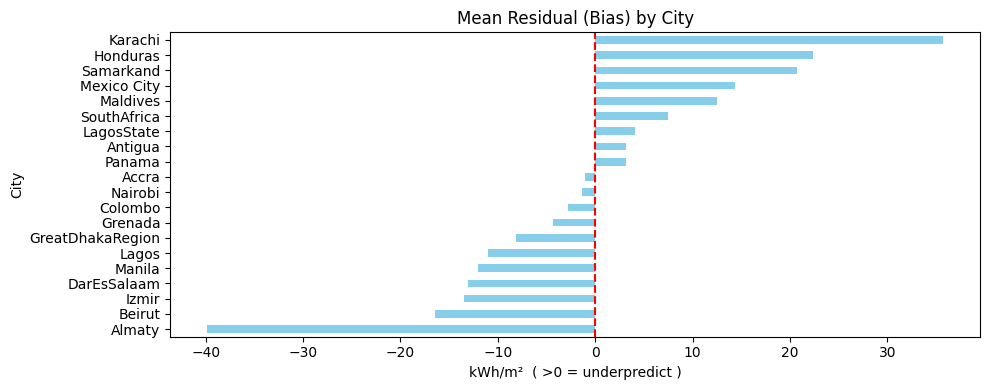

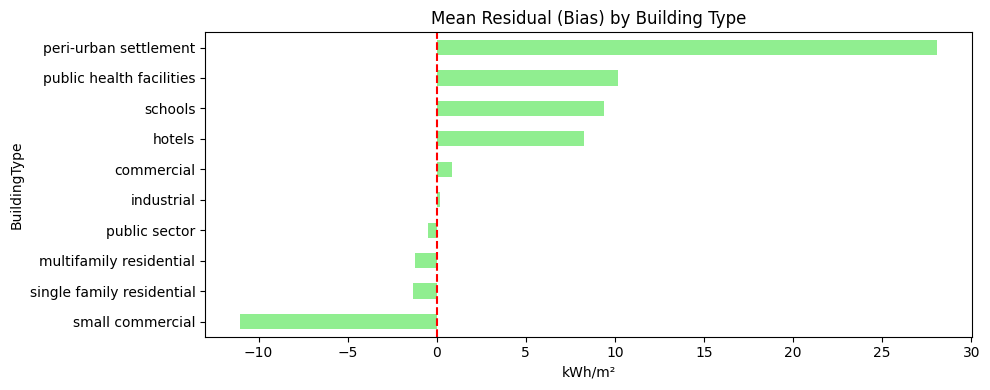

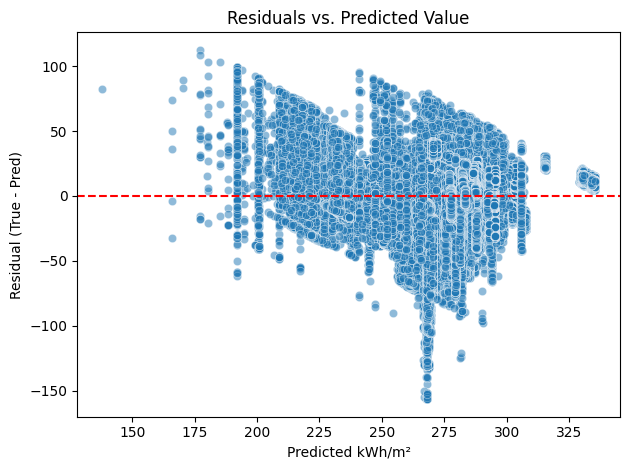

In [6]:
# Bias by City
plt.figure(figsize=(10,4))
city_bias.plot(kind="barh", color="skyblue")
plt.axvline(0, color="red", ls="--")
plt.title("Mean Residual (Bias) by City")
plt.xlabel("kWh/m²  ( >0 = underpredict )")
plt.tight_layout()
plt.show()

# Bias by BuildingType
plt.figure(figsize=(10,4))
type_bias.plot(kind="barh", color="lightgreen")
plt.axvline(0, color="red", ls="--")
plt.title("Mean Residual (Bias) by Building Type")
plt.xlabel("kWh/m²")
plt.tight_layout()
plt.show()

# Residual scatter
sns.scatterplot(x="y_pred", y="residual", data=oof_df, alpha=0.5)
plt.axhline(0, color="red", ls="--")
plt.title("Residuals vs. Predicted Value")
plt.xlabel("Predicted kWh/m²")
plt.ylabel("Residual (True - Pred)")
plt.tight_layout()
plt.show()


In [7]:
bias_by_city = oof_df.groupby("City")["residual"].mean()
oof_df["y_pred_corrected"] = oof_df["y_pred"] + oof_df["City"].map(bias_by_city)

overall_mae_before = mean_absolute_error(oof_df["y_true"], oof_df["y_pred"])
overall_mae_after  = mean_absolute_error(oof_df["y_true"], oof_df["y_pred_corrected"])
print(f"MAE before correction: {overall_mae_before:.3f}")
print(f"MAE after correction:  {overall_mae_after:.3f}")

MAE before correction: 16.599
MAE after correction:  10.313
